# Visualize Graph Data Model Using Diagram-as-Code: Property Graph

This notebook shows how to introspect property graph data in your Neptune database and draw a diagram representing the contents of that model. It uses a diagram-as-code approach. We use a combination of Neptune summary API and OpenCypher queries to discover your graph schema. We then use PlantUML to draw the schema.

### Min Requirement: 
- Neptune 1.2.x or higher
- Summary API must be working. See requirements https://docs.aws.amazon.com/neptune/latest/userguide/neptune-graph-summary.html. 

There is a companion notebook for RDF.


## Setup PlantUML
We will use Plant UML to render the diagram

In [ ]:
%pip install iplantuml

** Restart kernel **

In [ ]:
import iplantuml

## Setup Discovery
Get connection to Neptune

In [ ]:
import json
import os
import lpg_discovery

def get_neptune_env(var):
    return os.popen(f"source ~/.bashrc ; echo ${var}").read().split("\n")[0]
    
# Grab Neptune cluster host/port from notebook instance environment variables
GRAPH_NOTEBOOK_HOST= get_neptune_env("GRAPH_NOTEBOOK_HOST")
GRAPH_NOTEBOOK_PORT= get_neptune_env("GRAPH_NOTEBOOK_PORT")
GRAPH_NOTEBOOK_AUTH_MODE= get_neptune_env("GRAPH_NOTEBOOK_AUTH_MODE")
AWS_REGION= get_neptune_env("AWS_REGION")
USE_IAM_AUTH = GRAPH_NOTEBOOK_AUTH_MODE != 'DEFAULT'

lpg_discovery.set_neptune_env(
    host=GRAPH_NOTEBOOK_HOST, 
    port=GRAPH_NOTEBOOK_PORT, 
    region=AWS_REGION, 
    use_iam_auth=USE_IAM_AUTH)


## Load some data if you like
If not, skip and we'll go with what you've got

In [ ]:
%seed --model property_graph --dataset airports

In [ ]:
%seed --model property_graph --dataset fraud_graph

In [ ]:
%seed --model property_graph --dataset knowledge-graph

## Use Summary API to Get Schema

Start with summary API to get basic schema from stats

Then dig a bit deeper with some queries

Here's a reference: https://github.com/aws/amazon-neptune-for-graphql/blob/main/src/NeptuneSchema.js

In [ ]:
%summary --detail --store-to pgsummary propertygraph

## Run discovery
Run OpenCypher introspection queries.
The result is a list of introspected node types, their properties, their relationships.

In [ ]:
observation=lpg_discovery.discover(pgsummary)

observation


## Build PlantUML spec
Map the observed to UML class diagram PlantUML form.

In [ ]:
plantspec = lpg_discovery.to_plant_uml(observation)
print(plantspec)

## Render from the Spec
Draw it in PlantUML

In [ ]:
#import plantuml
ipython = get_ipython()
ipython.run_cell_magic("plantuml", "-n lpg_all", plantspec)

## Too much? Wittle it down

Just airport. 

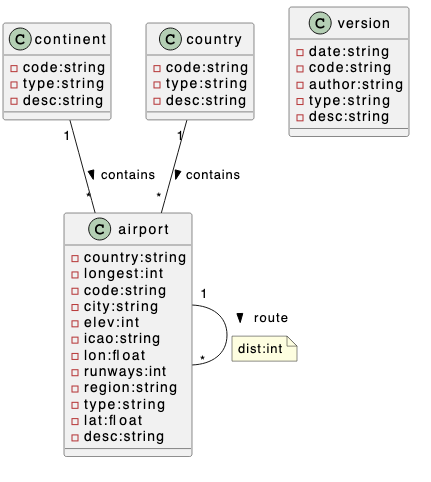

In [ ]:
class_filter = ["continent", "country", "airport", "version"]
plantspec = lpg_discovery.to_plant_uml(observation, class_filter=class_filter)
print(plantspec)

In [ ]:
ipython = get_ipython()
ipython.run_cell_magic("plantuml", "-n lpg_airport", plantspec)

In [ ]:
%%oc

MATCH(n:movie)-[e]->(m) 
WITH type(e) as edgetype, labels(m) as target 
LIMIT 5000

RETURN distinct edgetype, target
LIMIT 100